In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sciopt


import pandas as pd

# from scipy import stats
import scipy.integrate as scint

import statsmodels.api as sm

# import time

import seaborn as sns

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def model(t, X, params):
    """
    A function to return the slops of the ODE model given by Ackerman et al. Will be used for passing through scipy's ODE solvers

    t: system time

    X: A vector containing the values of V (viral load), I (Interferon level) and M (Macrophage amount).

    params: A vector containing all the parameters for the equations governing V, I and M in order.

    return: dV/dt, dI/dt and dM/dt


    """
    V, I, M = X

    rVV, kVV, rVI, rVM, dV = params[0:5]
    rIV, rIM, dI = params[5:8]
    rMI, kMI, dM, n = params[8:]

    dVdt = rVV * V * (1 - V / kVV) - rVI * V * I - rVM * V * (M - 1e07) - dV * V
    dIdt = rIV * V + rIM * (M - 1e07) - dI * I
    dMdt = rMI * I**n / (kMI + I**n) - dM * (M - 1e07)

    return np.array([dVdt, dIdt, dMdt])

<IPython.core.display.Javascript object>

These are the starting values used to evaluate the function.:

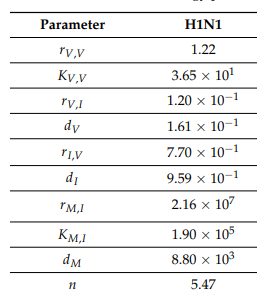

image from Ackerman et al.

In [3]:
rVV, kVV, rVI, rVM, dV = 1.22, 3.65 * 1e1, 1.21e-1, 1e-04, 1.61e-01
rIV, rIM, dI = 7.71e-01, 1e-04, 9.59 * 1e-01
rMI, kMI, dM, n = 2.16 * 1e07, 1.9 * 1e05, 8.8 * 1e03, 5.47

paramsV = np.array([rVV, kVV, rVI, rVM, dV])
paramsI = np.array([rIV, rIM, dI])
paramsM = np.array([rMI, kMI, dM, n])

paramstot = np.concatenate([paramsV, paramsI, paramsM], axis=None)

paramnames = {
    1: "$r_{V,V}$",
    2: "$k_{V,V}$",
    3: "$r_{V,I}$",
    4: "$r_{V,M}$",
    5: "$d_{V}$",
    6: "$r_{I,V}$",
    7: "$r_{I,M}$",
    8: "$d_{I}$",
    9: "$r_{M,I}$",
    10: "$k_{M,I}$",
    11: "$d_{M}$",
    12: "$n$",
}

init = np.array([6.3724, 0, 1e07])
t = np.linspace(0, 5, 100)

<IPython.core.display.Javascript object>

In [4]:
sol = scint.odeint(
    model,
    y0=init,
    t=t,
    tfirst=True,
    args=(tuple([np.array(paramstot)])),
)

ssval = sol[:][-1]

<IPython.core.display.Javascript object>

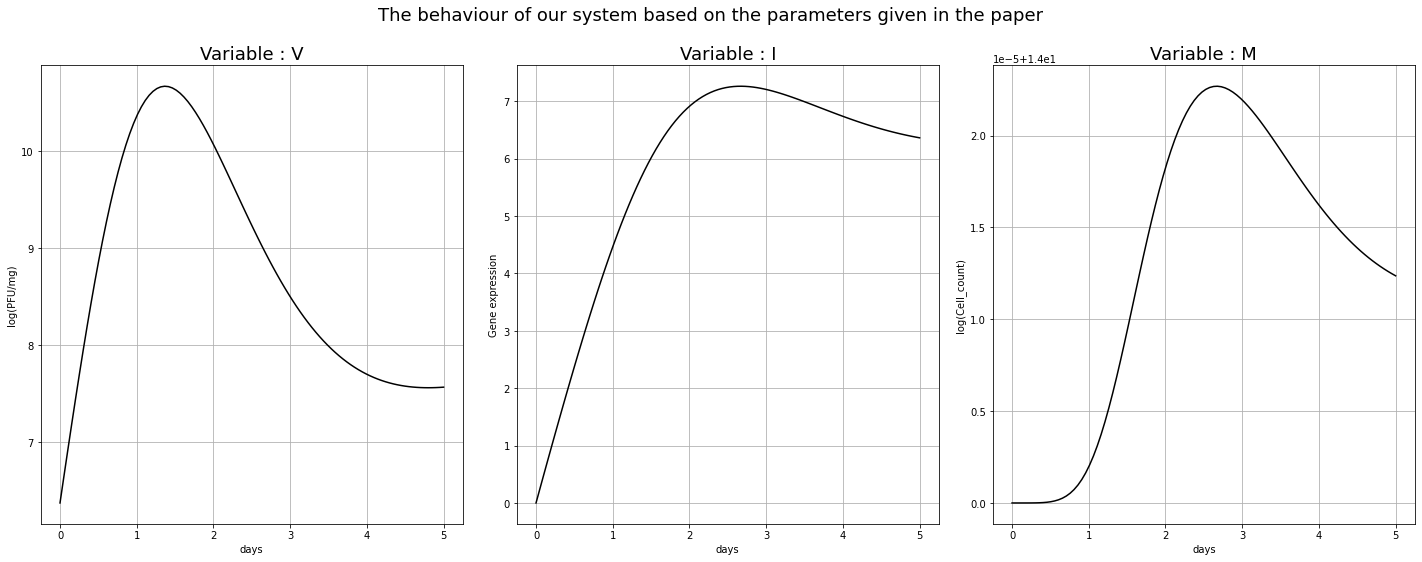

<IPython.core.display.Javascript object>

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
plt.rcParams.update({"font.size": 15})

axs[0].plot(t, sol.T[0], "k")
axs[1].plot(t, sol.T[1], "k")
axs[2].plot(t, np.log10(sol.T[2]) + np.log10(init[2]), "k")
for i in axs:
    i.set_xlabel("days")
    i.grid()
axs[0].set_title("Variable : V")
axs[1].set_title("Variable : I")
axs[2].set_title("Variable : M")

axs[0].set_ylabel("log(PFU/mg)")
axs[1].set_ylabel("Gene expression")
axs[2].set_ylabel("log(Cell_count)")
plt.suptitle("The behaviour of our system based on the parameters given in the paper")
fig.tight_layout()

This preliminary plot uses the parameters listed in the paper by Ackerman et al. This does follow the behaviours shown in the paper, but doesn't really have simlar values, especially for the macrophages

# Parametric sensitivity analysis

perturbation tests for all the parameters- to see which one is the most sensitive

We have a total of 12 parameters. Parameters $r_{I,M}$ and $r_{V,M}$ do not have any values listed in the paper, as all the values listed are for model 4. (This model ignores the macrophage induced regulation of interferon and inhibition of virus)
We take arbitrary values of 1e-04 just to check the sensitivity of these parameters wrt our system

In [6]:
soln = np.array([])

frac_dev = 20 / 100


df1 = pd.DataFrame()

samples = 5000
for i in np.arange(np.size(paramstot)):
    a = np.random.uniform(
        paramstot[i] * (1 - frac_dev), paramstot[i] * (1 + frac_dev), samples
    )

    df1[rf"{paramnames[i+1]}"] = a



<IPython.core.display.Javascript object>

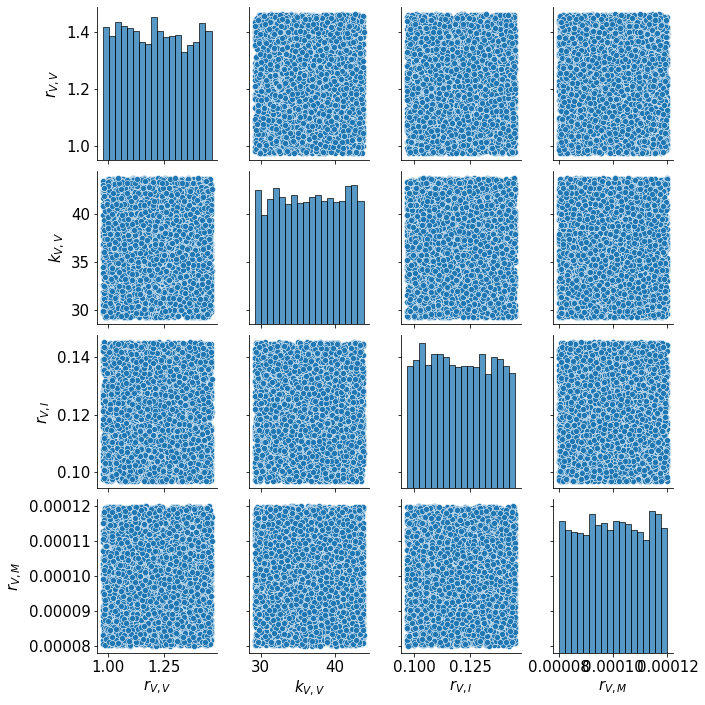

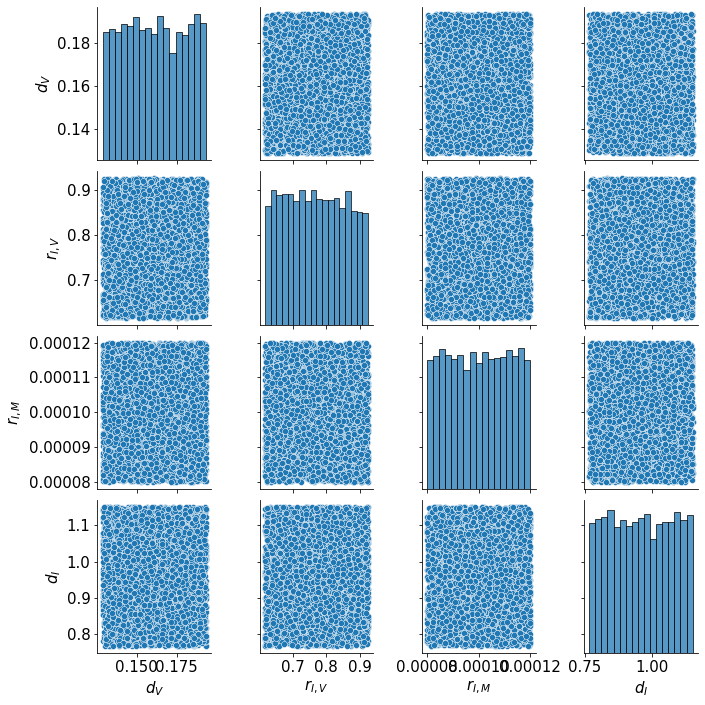

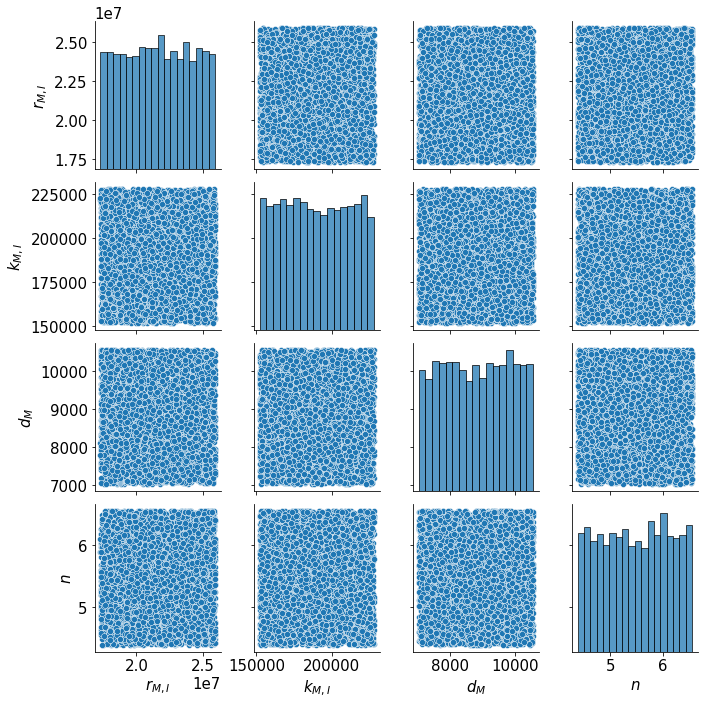

<IPython.core.display.Javascript object>

In [7]:
for i in np.arange(4, 13, 4):

    sns.pairplot(df1[df1.columns[i - 4 : i]])

All of the parameters seem uniform

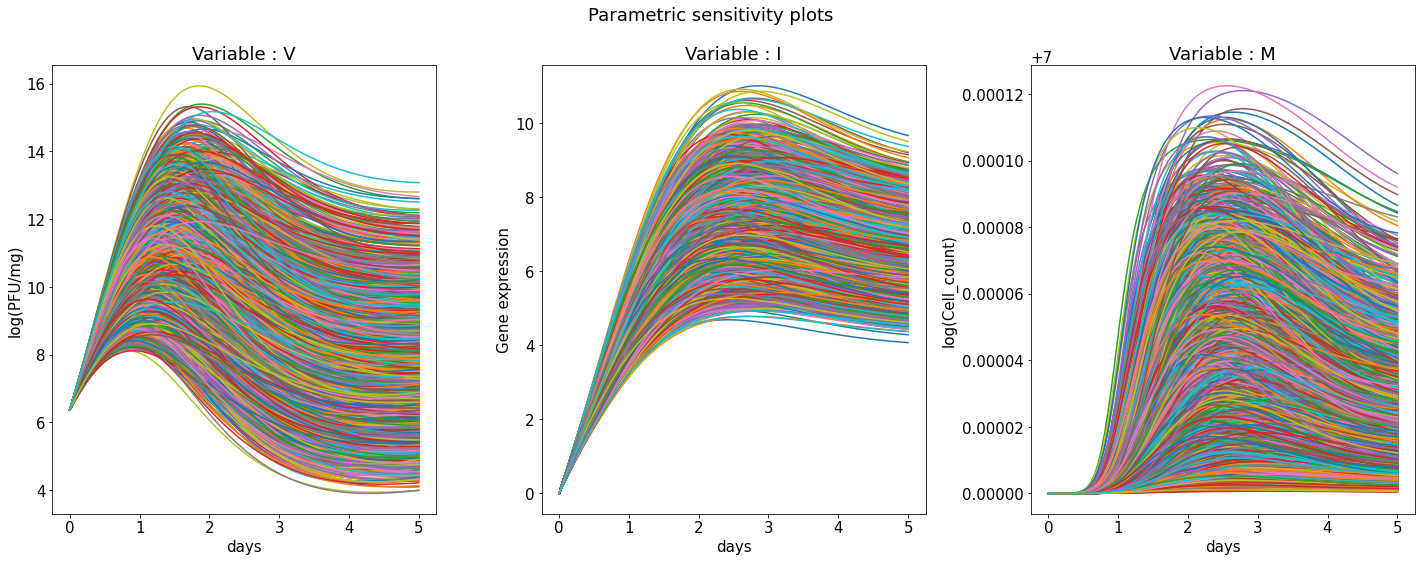

<IPython.core.display.Javascript object>

In [8]:
V = np.zeros(samples)
t = np.linspace(0, 5, 100)
I = np.zeros(samples)
M = np.zeros(samples)

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
plt.rcParams.update({"font.size": 15})
for i in np.arange(0, samples, 1):
    soln = scint.odeint(
        model,
        init,
        t,
        tfirst=True,
        args=(tuple([np.array(df1.iloc[i])])),
    )
    axs[0].plot(t, soln[:, 0])
    axs[1].plot(t, soln[:, 1])
    axs[2].plot(t, np.log10(soln[:, 2]))
    V[i] = soln[-1, 0]
    I[i] = soln[-1, 1]
    M[i] = soln[-1, 2]

fig.suptitle("Parametric sensitivity plots")
axs[0].set_title("Variable : V")
axs[1].set_title("Variable : I")
axs[2].set_title("Variable : M")

axs[0].set_ylabel("log(PFU/mg)")
axs[1].set_ylabel("Gene expression")
axs[2].set_ylabel("log(Cell_count)")

for i in axs:
    i.set_xlabel("days")
fig.tight_layout()

We can see that all the variables show a change in their steady state values when subject to a change in the parameters. We do not notice any behaviour changes for any of the variables by changing any parameter.

In [9]:
Vnorm = (ssval[0] - V) / ssval[0]
Inorm = (ssval[1] - I) / ssval[1]
Mnorm = (ssval[2] - M) / ssval[2]

<IPython.core.display.Javascript object>

In [10]:
df2 = df1.copy()
for i in np.arange(np.size(paramstot)):
    df2[df2.columns[i]] = df2[df2.columns[i]] - paramstot[i]

<IPython.core.display.Javascript object>

In [11]:
mod = sm.OLS(Vnorm, df2).fit()
print(mod.summary())



                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                          2.032e+04
Date:                Tue, 13 Dec 2022   Prob (F-statistic):                        0.00
Time:                        14:25:18   Log-Likelihood:                          10822.
No. Observations:                5000   AIC:                                 -2.162e+04
Df Residuals:                    4988   BIC:                                 -2.154e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<IPython.core.display.Javascript object>

Parametric sensitivity results

we can see that the variables $r_{V,M}$, $r_{I,M}$ have abnormally large values for their coefficients. This might because of the magnitude of the arbitrary, non zero value chosen to assess parametric sensitivity. We can also see that $r_{I,M}$ does not have a low p-value for our regression fit.  All the other parameters statistically fit into the regression, with p values close to 0. ( we have 1000 samples, so this was a given).

The most sensitive parameter is $r_{V,I}$, which coincides with what paper says.

In [12]:
print(
    rf"The slope obtained for the global sensitivity regression fit of the parameter $r_V,I$ is {mod.params[2]:.3f}"
)

The slope obtained for the global sensitivity regression fit of the parameter $r_V,I$ is 5.577


<IPython.core.display.Javascript object>

# Bifurcation Analysis

we select the parameter of interest as $r_{V,I}$. The rationale behind changing this parameter is that $r_{V,I}$ is the most sensitive parameter in our system, as found above. Thus, using it makes the most sense for our bifurcation analysis.

In [13]:
copy = np.concatenate([paramsV, paramsI, paramsM], axis=None)
copy[2] = copy[2] * 2

<IPython.core.display.Javascript object>

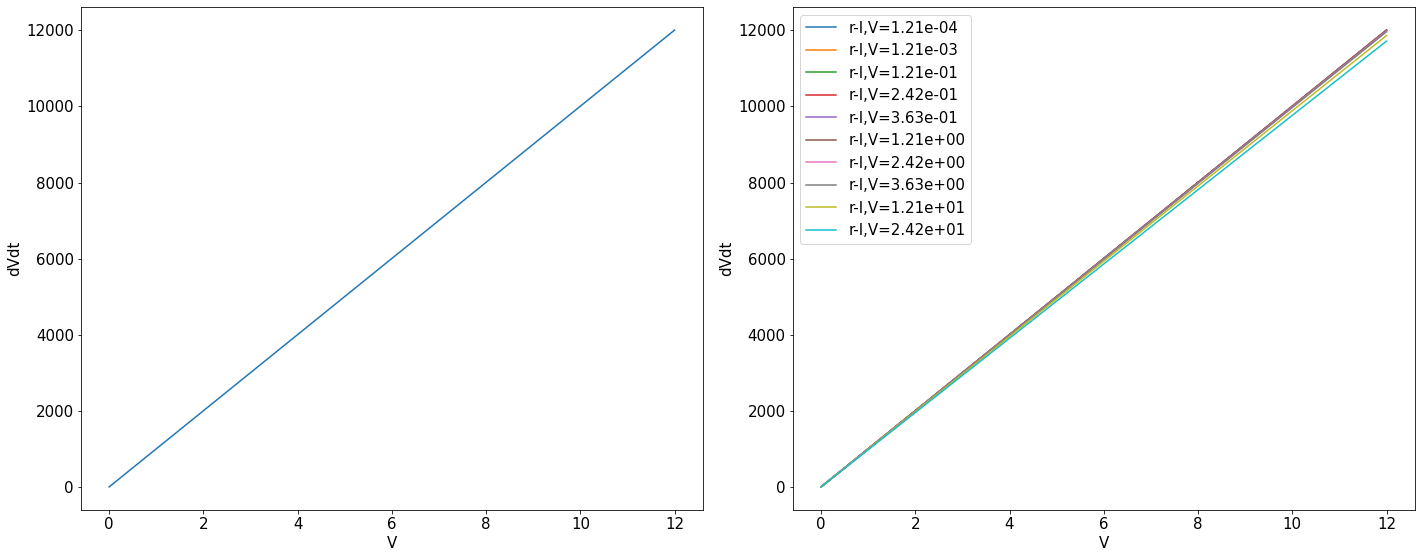

<IPython.core.display.Javascript object>

In [14]:
dummyv = np.linspace(0, 12, 100)
dummyi = np.ones_like(dummyv)
dummym = np.ones_like(dummyv)

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(
    dummyv,
    model(0, np.array([dummyv, dummyi, dummym]), paramstot)[0],
    label=rf"r_I,V ={paramstot[2]}",
)
for i in np.array([0.001, 0.01, 1, 2, 3, 10, 20, 30, 100, 200]):
    copy[2] = paramstot[2] * i
    axs[1].plot(
        dummyv,
        model(0, np.array([dummyv, dummyi, dummym]), copy)[0],
        label=rf"r-I,V={i*paramstot[2]:1.2e}",
    )

for i in axs:
    i.set_xlabel("V")
    i.set_ylabel("dVdt")
fig.tight_layout()
plt.legend()

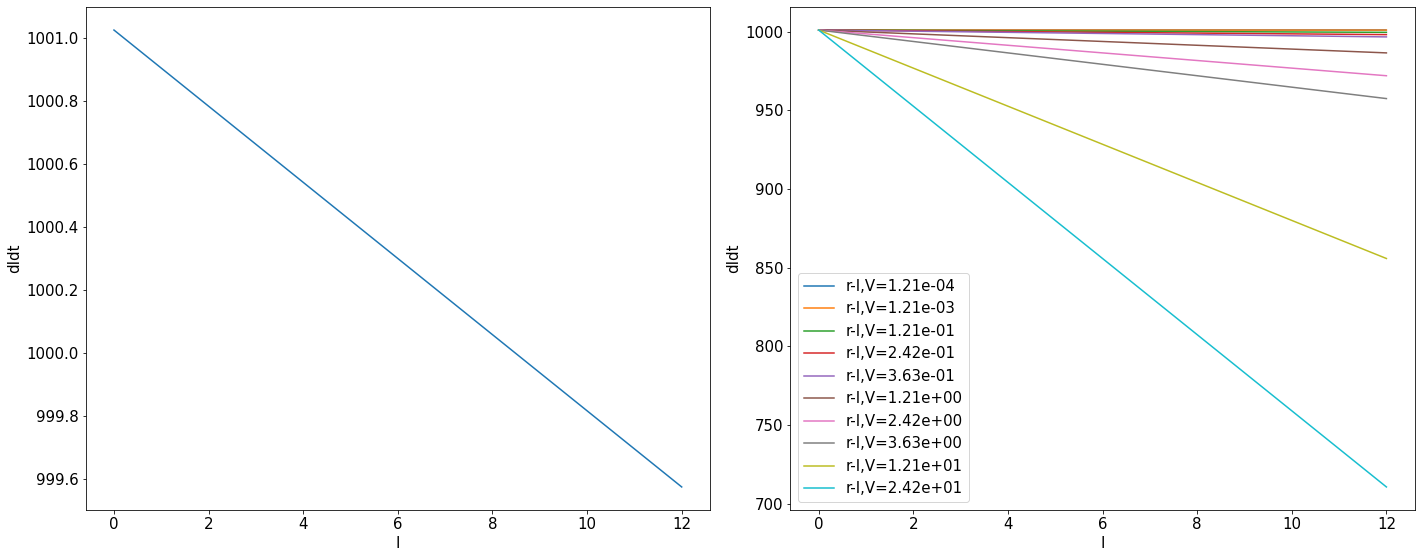

<IPython.core.display.Javascript object>

In [15]:
dummyi = np.linspace(0, 12, 100)
dummyv = np.ones_like(dummyv)
dummym = np.ones_like(dummyv)

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(
    dummyi,
    model(0, np.array([dummyv, dummyi, dummym]), paramstot)[0],
    label=rf"r_I,V ={paramstot[2]}",
)
for i in np.array([0.001, 0.01, 1, 2, 3, 10, 20, 30, 100, 200]):
    copy[2] = paramstot[2] * i
    axs[1].plot(
        dummyi,
        model(0, np.array([dummyv, dummyi, dummym]), copy)[0],
        label=rf"r-I,V={i*paramstot[2]:1.2e}",
    )

for i in axs:
    i.set_xlabel("I")
    i.set_ylabel("dIdt")
fig.tight_layout()
plt.legend()

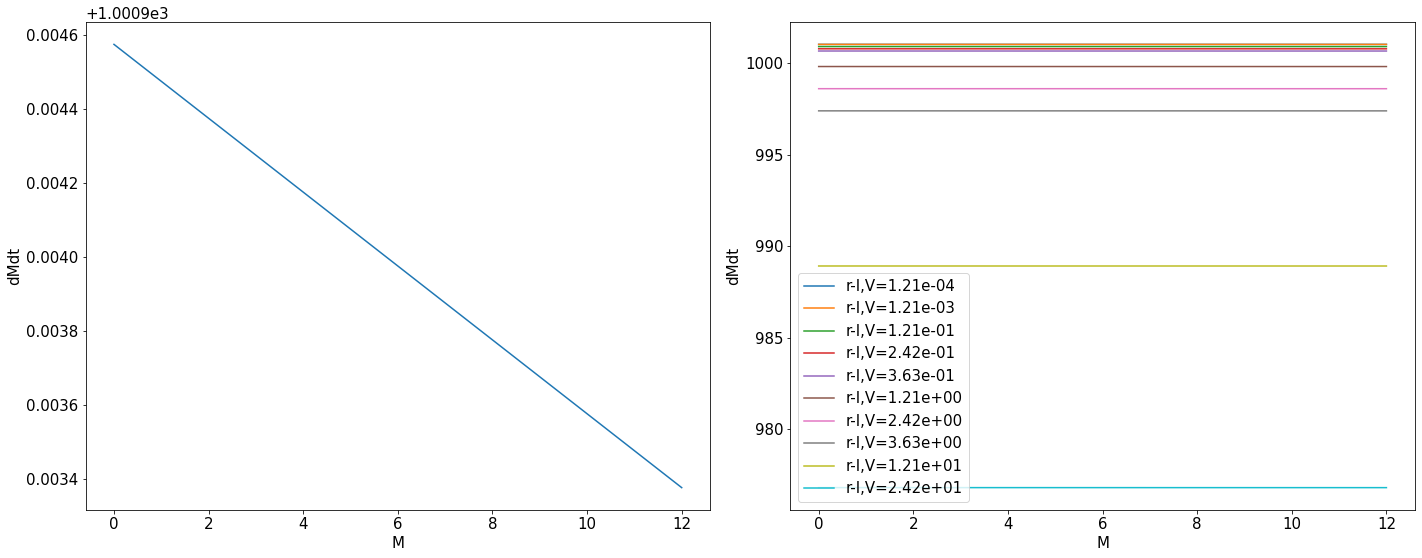

<IPython.core.display.Javascript object>

In [16]:
dummym = np.linspace(0, 12, 100)
dummyv = np.ones_like(dummyv)
dummyi = np.ones_like(dummyv)

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(
    dummym,
    model(0, np.array([dummyv, dummyi, dummym]), paramstot)[0],
    label=rf"r_I,V ={paramstot[2]}",
)
for i in np.array([0.001, 0.01, 1, 2, 3, 10, 20, 30, 100, 200]):
    copy[2] = paramstot[2] * i
    axs[1].plot(
        dummym,
        model(0, np.array([dummyv, dummyi, dummym]), copy)[0],
        label=rf"r-I,V={i*paramstot[2]:1.2e}",
    )

for i in axs:
    i.set_xlabel("M")
    i.set_ylabel("dMdt")
fig.tight_layout()
plt.legend()

# Data fitting

The data provided in the paper


We will only be using 2 data points, one at t = 0 days and at t = 8 days.

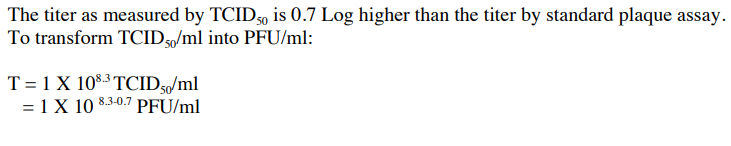

|t|log(PFU)/mouse|
|--|----|
|0|5.25|
|5|13.56|
|8|6.87|

In [17]:
def rmse(par, tt):
    rVV, kVV, rVI, rVM, dV, rIV, rIM, dI, rMI, kMI, dM, n = par

    par2 = rVV, kVV, rVI, rVM, dV, rIV, rIM, dI, rMI, kMI, dM, n

    solution = scint.odeint(
        model,
        init,
        tt,
        args=(tuple([np.array(par2)])),
        tfirst=True,
    )
    error = training_data - solution.T[0]
    #     error = error / [4.5, 1.5]
    # print(error)
    #     error = error/np.max(error)
    return np.sqrt(np.sum(error**2))

<IPython.core.display.Javascript object>

In [18]:
training_data = np.array(
    [5.25, 13.75, 6.87],
)
training_data

array([ 5.25, 13.75,  6.87])

<IPython.core.display.Javascript object>

In [19]:
t1a = np.array([0, 5, 8])
attempt1 = sciopt.minimize(rmse, x0=(paramstot * 1.2), args=(t1a))
print(rmse(attempt1.x, t1a))

C:\Users\srks9\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


4.993255293639894


<IPython.core.display.Javascript object>

In [20]:
100 * (attempt1.x - paramstot) / paramstot

array([   32.55968262,    19.9380235 ,    55.73779237,  -395.90471041,
         117.28488204,    18.38160166, -1289.82509461,    16.36316043,
          20.00000021,    20.00003106,    20.00089136,    19.27450071])

<IPython.core.display.Javascript object>

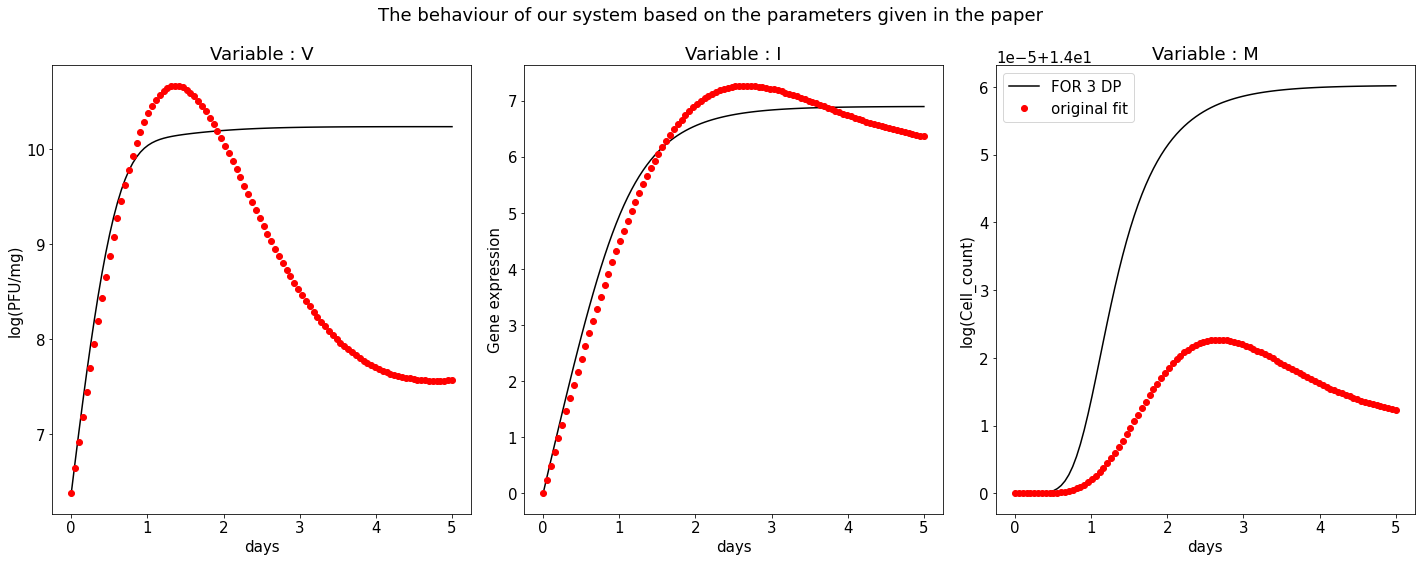

<IPython.core.display.Javascript object>

In [21]:
sola = scint.odeint(
    model,
    y0=init,
    t=t,
    tfirst=True,
    args=(tuple([np.array(attempt1.x)])),
)

fig, axs = plt.subplots(1, 3, figsize=(20, 8))

axs[0].plot(t, sola.T[0], "k")
axs[1].plot(t, sola.T[1], "k")
axs[2].plot(t, np.log10(sola.T[2]) + np.log10(init[2]), "k", label="FOR 3 DP")

axs[0].plot(t, sol.T[0], "ro")
axs[1].plot(t, sol.T[1], "ro")
axs[2].plot(t, np.log10(sol.T[2]) + np.log10(init[2]), "ro", label="original fit")

plt.legend()

for i in axs:
    i.set_xlabel("days")
axs[0].set_title("Variable : V")
axs[1].set_title("Variable : I")
axs[2].set_title("Variable : M")

axs[0].set_ylabel("log(PFU/mg)")
axs[1].set_ylabel("Gene expression")
axs[2].set_ylabel("log(Cell_count)")
plt.suptitle("The behaviour of our system based on the parameters given in the paper")
fig.tight_layout()

In [22]:
t1 = np.array(
    [0.115, 0.125, 0.253, 0.379, 0.505, 0.758, 1, 1.253, 1.506, 2.01, 2.501, 3, 5]
)
v1 = np.array(
    [
        6.806,
        6.384,
        7.846,
        8.577,
        9.185,
        10.04,
        10.362,
        10.586,
        10.326,
        9.250,
        9.759,
        9.067,
        8.886,
    ]
)

training_data = v1

<IPython.core.display.Javascript object>

In [23]:
attempt2 = sciopt.minimize(rmse, x0=(paramstot), args=(t1))
# print(attempt1)
# print(rmse(attempt1.x, t1))

<IPython.core.display.Javascript object>

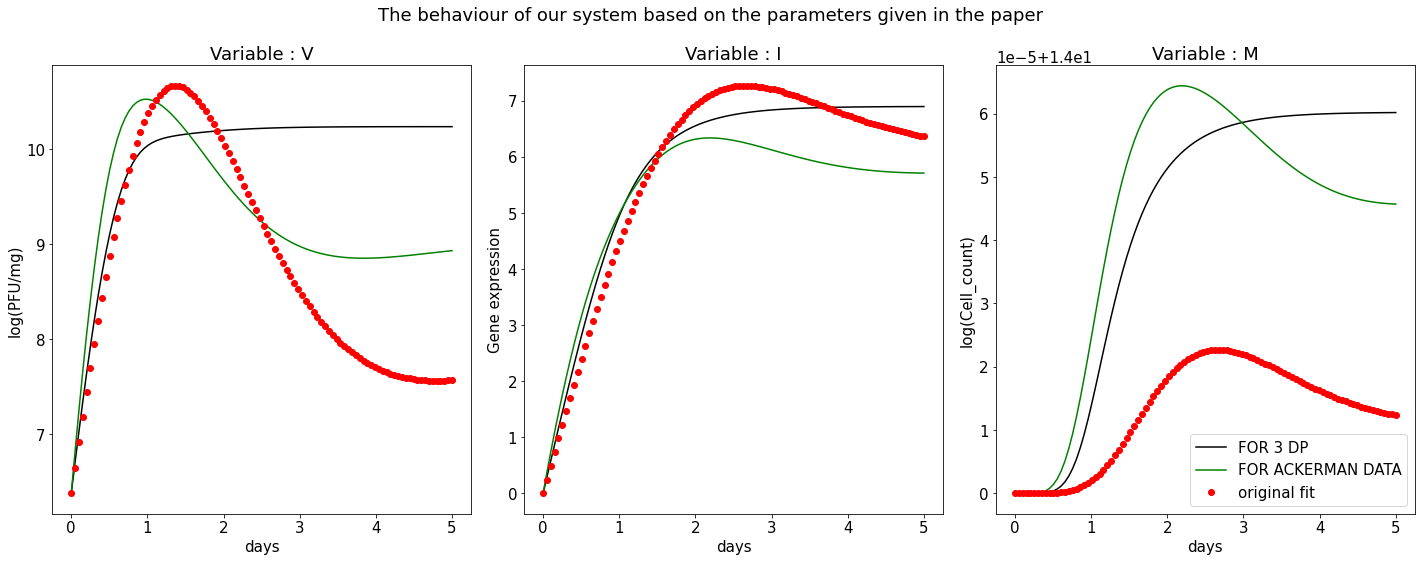

<IPython.core.display.Javascript object>

In [24]:
sola = scint.odeint(
    model,
    y0=init,
    t=t,
    tfirst=True,
    args=(tuple([np.array(attempt1.x)])),
)
sola2 = scint.odeint(
    model,
    y0=init,
    t=t,
    tfirst=True,
    args=(tuple([np.array(attempt2.x)])),
)
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

axs[0].plot(t, sola.T[0], "k", label="FOR 3 DP")
axs[1].plot(t, sola.T[1], "k", label="FOR 3 DP")
axs[2].plot(t, np.log10(sola.T[2]) + np.log10(init[2]), "k", label="FOR 3 DP")

axs[0].plot(t, sola2.T[0], "g", label="FOR ACKERMAN DATA")
axs[1].plot(t, sola2.T[1], "g", label="FOR ACKERMAN DATA")
axs[2].plot(t, np.log10(sola2.T[2]) + np.log10(init[2]), "g", label="FOR ACKERMAN DATA")

axs[0].plot(t, sol.T[0], "ro", label="original fit")
axs[1].plot(t, sol.T[1], "ro", label="original fit")
axs[2].plot(t, np.log10(sol.T[2]) + np.log10(init[2]), "ro", label="original fit")

plt.legend()
for i in axs:
    i.set_xlabel("days")
axs[0].set_title("Variable : V")
axs[1].set_title("Variable : I")
axs[2].set_title("Variable : M")

axs[0].set_ylabel("log(PFU/mg)")
axs[1].set_ylabel("Gene expression")
axs[2].set_ylabel("log(Cell_count)")
plt.suptitle("The behaviour of our system based on the parameters given in the paper")
fig.tight_layout()
